In [1]:
%load_ext autoreload
%autoreload 2

# Import packages

In [2]:
import pandas as pd
import numpy as np
from dotenv import load_dotenv
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder, RobustScaler, MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import accuracy_score, classification_report, silhouette_score, confusion_matrix
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
import scipy.cluster.hierarchy as shc 
from sklearn.neighbors import NearestNeighbors
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import RandomForestClassifier



warnings.filterwarnings('ignore')

# Loading the data

In [3]:
load_dotenv()

True

In [4]:
data_get_env =os.getenv("DATA_HR")
data_get_env = "../"+data_get_env
data_get_env

'../raw_data/HR_Engagement_Sat_Sales_UpdatedV4.0.csv'

In [5]:
# # Set the working directory
# os.chdir('/Users/felixhaberl/code/Emroullier/hr-data-analytics')

In [6]:
print(os.getcwd())

/home/thierry/code/Emroullier/hr-data-analytics/notebooks


In [7]:
data = pd.read_csv(data_get_env)

In [8]:
data.head(5)

ID      Name       Department     GEO             Role  Rising_Star  \
0   1    BRADDY       Operations      US               VP          NaN   
1   2     BORST            Sales      UK  Senior Director          NaN   
2   3  BIRDWELL          Finance  France  Senior Director          NaN   
3   4      BENT  Human Resources   China  Senior Director          NaN   
4   5     BAZAN               IT   Korea         Director          NaN   

   Will_Relocate  Critical  Trending Perf  Talent_Level  ...  \
0              0       1.0              3             6  ...   
1              0       NaN              3             6  ...   
2              0       NaN              3             6  ...   
3              0       NaN              3             6  ...   
4              0       NaN              3             6  ...   

   Emp_Competitive_4  Emp_Competitive_5  Emp_Collaborative_1  \
0                  2                  2                    2   
1                  4                  1                    3   
2                  2                  5                    2   
3                  5                  1                    1   
4                  5                  3                    5   

   Emp_Collaborative_2  Emp_Collaborative_3  Emp_Collaborative_4  \
0                    2                    2                    1   
1                    2                    5                    1   
2                    2                    4                    4   
3                    2                    4                    4   
4                    1                    2                    5   

   Emp_Collaborative_5  Sensor_StepCount  Sensor_Heartbeat(Average/Min)  \
0                    5              1841                             61   
1                    5              1990                             90   
2                    4              3193                             80   
3                    1              3248                             77   
4                    4              3149                             80   

   Sensor_Proximity(1-highest/10-lowest)  
0                                      9  
1                                      8  
2                                      8  
3                                      6  
4                                     10  

[5 rows x 62 columns]

# Data Preparation

In [9]:
data.drop(columns = ['ID','Name','Rising_Star', 'Trending Perf', 'Talent_Level',
                     'Validated_Talent_Level', 'EMP_Sat_OnPrem_1', 'EMP_Sat_OnPrem_2',
                     'EMP_Sat_OnPrem_3','EMP_Sat_Remote_3', 'EMP_Sat_Remote_4','EMP_Sat_Remote_5',
                     'EMP_Engagement_2','EMP_Engagement_3','EMP_Engagement_4',
                     'EMP_Engagement_5','CSR Factor','sales'], inplace = True)

data = data.rename(columns={
    'Sensor_Heartbeat(Average/Min)': 'Sensor_Heartbeat',
    'Sensor_Proximity(1-highest/10-lowest)': 'Sensor_Proximity'
})

In [10]:
# Convert column names to lower snake case
data.columns = data.columns.str.lower().str.replace(' ', '_').str.replace('-', '_').str.replace('.', '_')

In [11]:
# combine all the men_leave and the women_leave column

data['leave'] = data['women_leave'].fillna(data['men_leave'])
data['leave'] = data['leave'].fillna(0)
data.drop(columns = ['women_leave', 'men_leave'], inplace = True)


# General Prerequisites

In [12]:
# checking missing values

data.isnull().sum().sort_values(ascending=False)


critical                 14519
emp_sat_onprem_4           128
emp_sat_onprem_5           128
department                   0
emp_competitive_5            0
emp_identity                 0
emp_role                     0
emp_position                 0
emp_title                    0
emp_competitive_1            0
emp_competitive_2            0
emp_competitive_3            0
emp_competitive_4            0
emp_collaborative_2          0
emp_collaborative_1          0
emp_work_status_4            0
emp_collaborative_3          0
emp_collaborative_4          0
emp_collaborative_5          0
sensor_stepcount             0
sensor_heartbeat             0
sensor_proximity             0
emp_work_status_5            0
emp_work_status2             0
emp_work_status_3            0
number_project               0
role                         0
will_relocate                0
percent_remote               0
emp_sat_remote_1             0
emp_sat_remote_2             0
emp_engagement_1             0
last_eva

In [13]:
# impute binary missing values for critical column

data.loc[data['critical'].isna(), 'critical'] = 0


In [14]:
# covert gender column into binary classification column

data['gender'] = data['gender'].map({'F': 1, 'M': 0})


In [15]:
# impute missing values with mode as these are ranking/ordinal columns
columns_to_impute = ['emp_sat_onprem_4', 'emp_sat_onprem_5']

imputer = SimpleImputer(strategy='most_frequent')

data[columns_to_impute] = imputer.fit_transform(data[columns_to_impute])


In [16]:
# target imbalancing
# the target is imbalanced, however this can be sorted using the class_weight='balanced' when using LogisticRegression

data['left_company'].value_counts(normalize = True)


left_company
0    0.761917
1    0.238083
Name: proportion, dtype: float64

# Numerical Features Data Cleaning ONLY

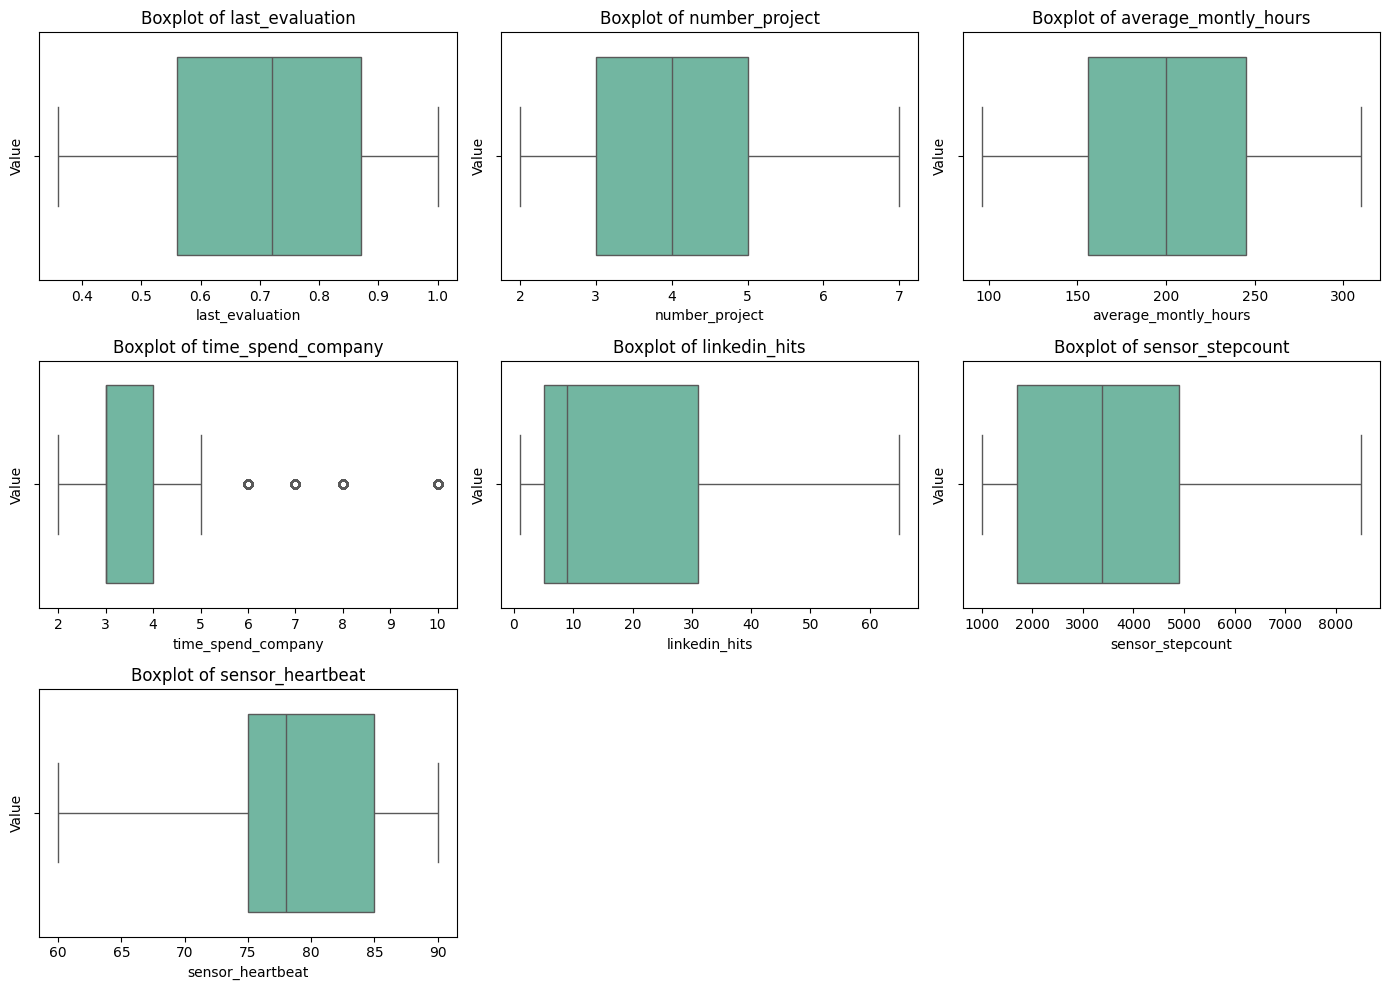

In [17]:
# detecting outliers with numerical columns only

numerical_columns = ['last_evaluation', 'number_project', 'average_montly_hours',
                     'time_spend_company', 'linkedin_hits', 'sensor_stepcount',
                     'sensor_heartbeat']

plt.figure(figsize=(14, 10))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x=data[column], palette='Set2')
    plt.title(f'Boxplot of {column}')
    plt.xlabel(column)
    plt.ylabel('Value')

plt.tight_layout()
plt.show()

In [18]:
# time_spend_company is the only numeric variable with outliers therefore we will use the Robust Scaler.

rb_scaler = RobustScaler()
data['time_spend_company'] = rb_scaler.fit_transform(data[['time_spend_company']])


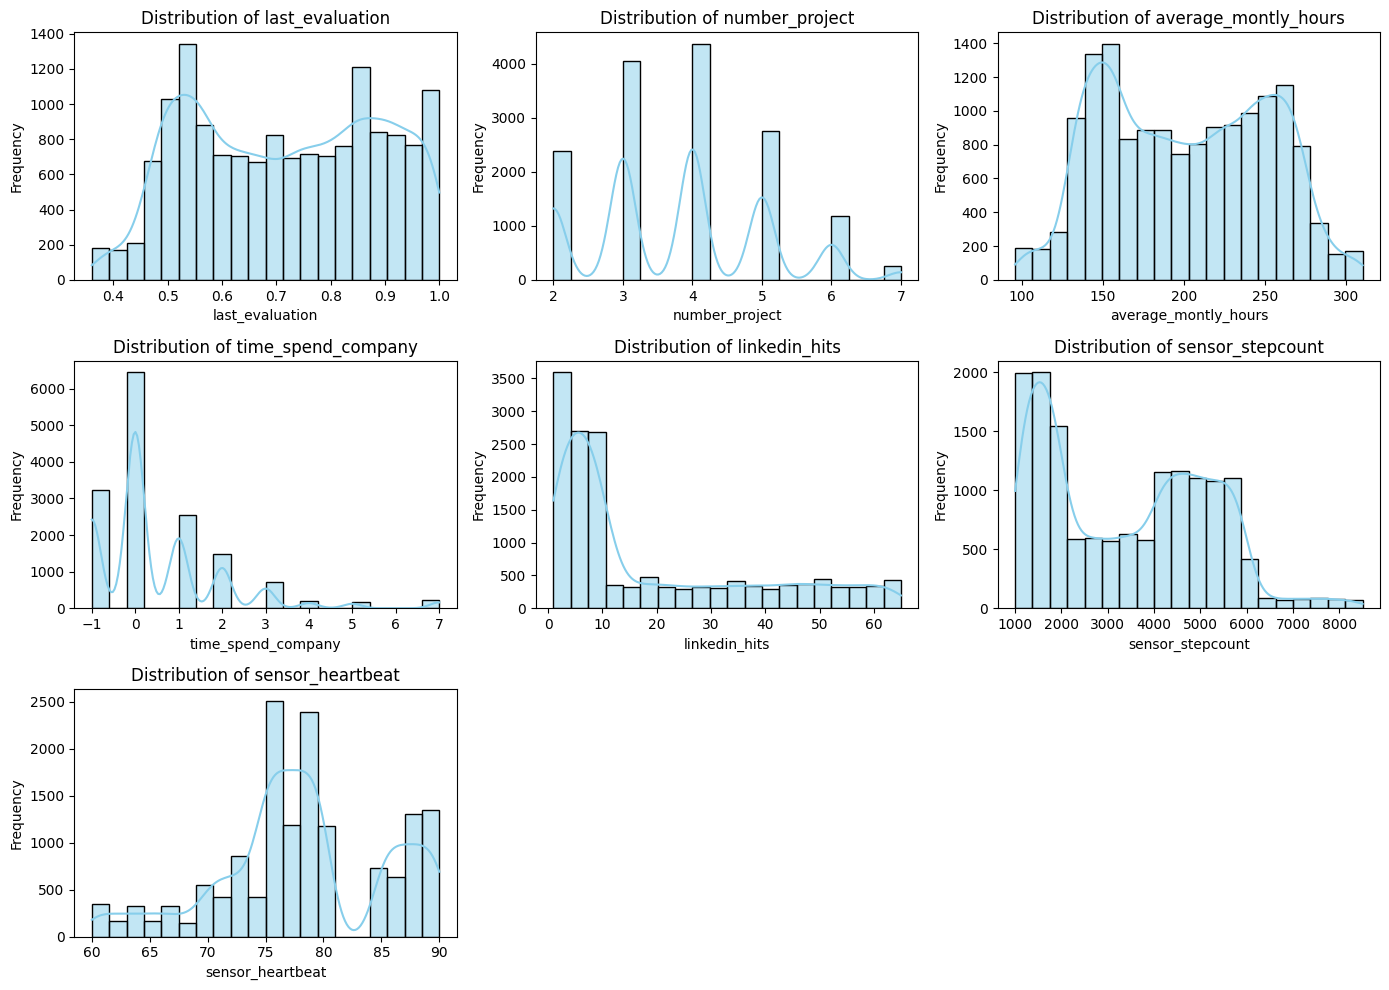

In [19]:
# plot the distributions of the numerical features to determine which scalers to use
# none of the plots seems to be normally distributed so the MinMaxScaling is chosen

plt.figure(figsize=(14, 10))
for i, column in enumerate(numerical_columns, 1):
    plt.subplot(3, 3, i)
    sns.histplot(data[column], kde=True, color='skyblue', bins=20)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [20]:
# for all other numerical variables, use the minmaxscaler

minmaxscaler_columns = ['last_evaluation', 'number_project', 'average_montly_hours',
                     'linkedin_hits', 'sensor_stepcount', 'sensor_heartbeat']

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the data using MinMaxScaler
data[minmaxscaler_columns] = scaler.fit_transform(data[minmaxscaler_columns])


# Categorical Features ONLY Feature Engineering

In [21]:
# ordinal encoding for salary

ordinal_encoder = OrdinalEncoder()
ordinal_encoder.fit(data[['salary']])
data['encoded_salary'] = ordinal_encoder.transform(data[['salary']]) # 1 = low, 2 = medium, 3 = high
data.drop(columns = ['salary'], inplace = True)


In [22]:
# OneHotEncoding for department, geo and role

ohe_columns = ['department', 'geo', 'role']

ohe = OneHotEncoder(sparse_output = False)

ohe_data = ohe.fit_transform(data[ohe_columns])

ohe_df = pd.DataFrame(ohe_data, columns=ohe.get_feature_names_out(ohe_columns))

encoded_data = pd.concat([data, ohe_df], axis=1)

encoded_data.drop(columns = ['department', 'geo', 'role'], inplace = True)


# Variable allocation

In [23]:
# define x and y variables

X = encoded_data.drop(columns = 'left_company')

y = encoded_data['left_company']


# Feature correlation

<Axes: >

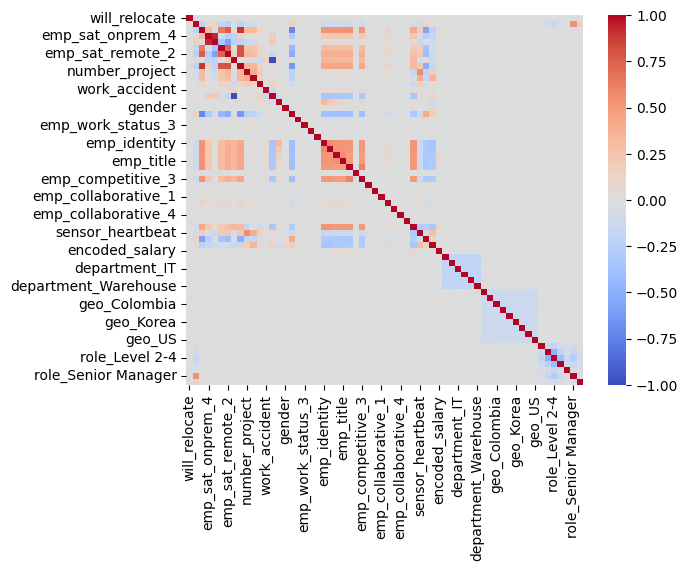

In [24]:
# Correlation Matrix
sns.heatmap(encoded_data.corr(), cmap='coolwarm')


In [25]:
# visualise the correlation

# Calculate the correlation matrix
corr_matrix = encoded_data.corr()

# Create an empty list to store correlation pairs
correlation_pairs = []

# Iterate through the correlation matrix
for i, col in enumerate(corr_matrix.columns):
    for j, index in enumerate(corr_matrix.index):
        if i < j:  # Only store pairs once to avoid duplicates and self-correlation
            correlation_pairs.append([index, col, corr_matrix.iloc[j, i]])

# Convert the list to a DataFrame
corr_df = pd.DataFrame(correlation_pairs, columns=['feature_1', 'feature_2', 'correlation'])

corr_df.sort_values(by="correlation",ascending=False, inplace=True) # sort by correlation

corr_df = corr_df[corr_df['feature_1'] != corr_df['feature_2']] # Remove self correlation

corr_df.head()


feature_1         feature_2  correlation
180  emp_sat_onprem_5  emp_sat_onprem_4     0.930062
126   last_evaluation    percent_remote     0.897223
352   last_evaluation  emp_sat_remote_2     0.805922
297   last_evaluation  emp_sat_remote_1     0.796292
124  emp_sat_remote_2    percent_remote     0.762327

In [26]:
# remove highly correlated features >= 0.7 or <= -0.7

correlated_features = corr_df[(corr_df['correlation'] >= 0.7) | (corr_df['correlation'] <= -0.7)]

X.drop(columns = ['emp_sat_onprem_4', 'percent_remote', 'emp_sat_remote_2', 'emp_sat_remote_1', 'emp_engagement_1','critical','emp_competitive_1','emp_competitive_2','emp_competitive_3','emp_competitive_4','emp_competitive_5','emp_collaborative_1','emp_collaborative_2','emp_collaborative_3','emp_collaborative_4','emp_collaborative_5'], inplace = True)


In [27]:
X.isnull().sum().sort_values(ascending=False)

will_relocate                 0
department_Finance            0
department_IT                 0
department_Operations         0
department_Sales              0
department_Warehouse          0
geo_Australia                 0
geo_China                     0
geo_Colombia                  0
geo_France                    0
geo_Japan                     0
geo_Korea                     0
geo_Turkey                    0
geo_UK                        0
geo_US                        0
role_Director                 0
role_Level 1                  0
role_Level 2-4                0
role_Manager                  0
role_Senior Director          0
role_Senior Manager           0
department_Human Resources    0
encoded_salary                0
emp_sat_onprem_5              0
leave                         0
last_evaluation               0
number_project                0
average_montly_hours          0
time_spend_company            0
work_accident                 0
promotion_last_5years         0
gender  

## Random Forrest


In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [29]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [30]:
# Evaluate the model
y_pred_rf = rf.predict(X_test)
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2286
           1       0.99      0.98      0.99       714

    accuracy                           0.99      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       0.99      0.99      0.99      3000

Confusion Matrix:
[[2280    6]
 [  12  702]]


## Evaluating the model


In [31]:
y_pred_rf = rf.predict(X_test)
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf))

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      2286
           1       0.99      0.98      0.99       714

    accuracy                           0.99      3000
   macro avg       0.99      0.99      0.99      3000
weighted avg       0.99      0.99      0.99      3000

Confusion Matrix:
[[2280    6]
 [  12  702]]


## Feature importance


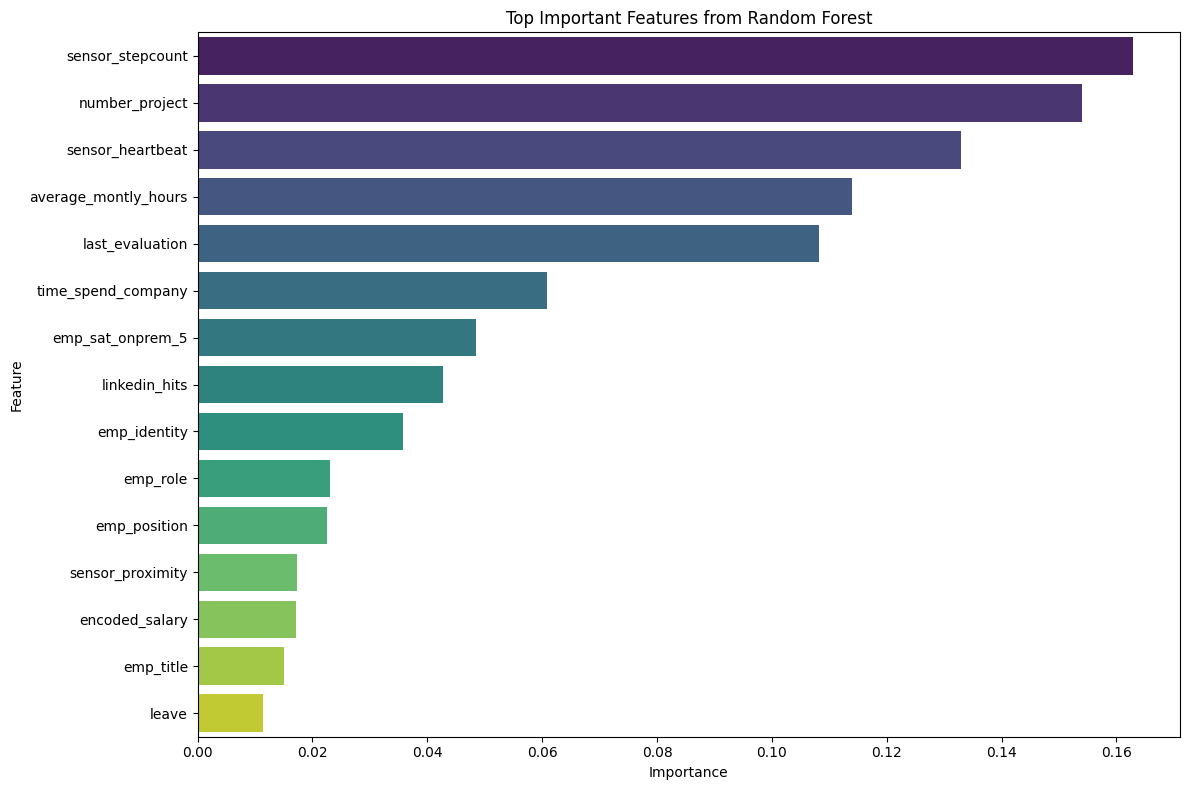

In [32]:
feature_names = X.columns.tolist()

rf_feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf.feature_importances_
})

# Filter features with importance greater than 0.01
rf_feature_importance = rf_feature_importance[rf_feature_importance['Importance'] > 0.01]

# Plotting feature importance using Seaborn for better visualization
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=rf_feature_importance.sort_values(by='Importance', ascending=False), palette='viridis')
plt.title('Top Important Features from Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

### Feature Selection

In [33]:
selected_features = ['last_evaluation', 'number_project', 'average_montly_hours', 'sensor_stepcount','sensor_heartbeat'] #'time_spend_company'
X = X[selected_features]
X_scaled=X
X_scaled

last_evaluation  number_project  average_montly_hours  \
0                  0.0             0.2              0.336449   
1                  0.0             0.6              0.294393   
2                  0.0             0.0              0.869159   
3                  0.0             0.4              0.850467   
4                  0.0             0.8              0.747664   
...                ...             ...                   ...   
14994              1.0             0.4              0.728972   
14995              1.0             0.4              0.635514   
14996              1.0             0.6              0.682243   
14997              1.0             0.6              0.593458   
14998              1.0             0.0              0.275701   

       sensor_stepcount  sensor_heartbeat  
0              0.112133          0.033333  
1              0.132000          1.000000  
2              0.292400          0.666667  
3              0.299733          0.566667  
4              0.286533          0.666667  
...                 ...               ...  
14994          0.071733          0.933333  
14995          0.032933          0.966667  
14996          0.020667          0.933333  
14997          0.028000          0.866667  
14998          0.085200          0.866667  

[14999 rows x 5 columns]

# Unsupervised Learning

In [34]:
# Create a copy of X to store the clusters and add company left
X_cluster=X
X_cluster['left_company']=data['left_company']
X_cluster

last_evaluation  number_project  average_montly_hours  \
0                  0.0             0.2              0.336449   
1                  0.0             0.6              0.294393   
2                  0.0             0.0              0.869159   
3                  0.0             0.4              0.850467   
4                  0.0             0.8              0.747664   
...                ...             ...                   ...   
14994              1.0             0.4              0.728972   
14995              1.0             0.4              0.635514   
14996              1.0             0.6              0.682243   
14997              1.0             0.6              0.593458   
14998              1.0             0.0              0.275701   

       sensor_stepcount  sensor_heartbeat  left_company  
0              0.112133          0.033333             0  
1              0.132000          1.000000             0  
2              0.292400          0.666667             0  
3              0.299733          0.566667             0  
4              0.286533          0.666667             0  
...                 ...               ...           ...  
14994          0.071733          0.933333             1  
14995          0.032933          0.966667             1  
14996          0.020667          0.933333             1  
14997          0.028000          0.866667             1  
14998          0.085200          0.866667             1  

[14999 rows x 6 columns]

## K-Means (Emily)

### PCA 

In [35]:

# Add the cluster labels to the original data

# Reduce dimensions to 2D for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

### Five clusters

Cluster Centers:
 [[-0.23937494 -0.02321102]
 [ 0.87986124  0.42602738]
 [ 0.62197726 -0.7499544 ]
 [-0.23485394  0.23501882]
 [-0.26004729 -0.45574826]]


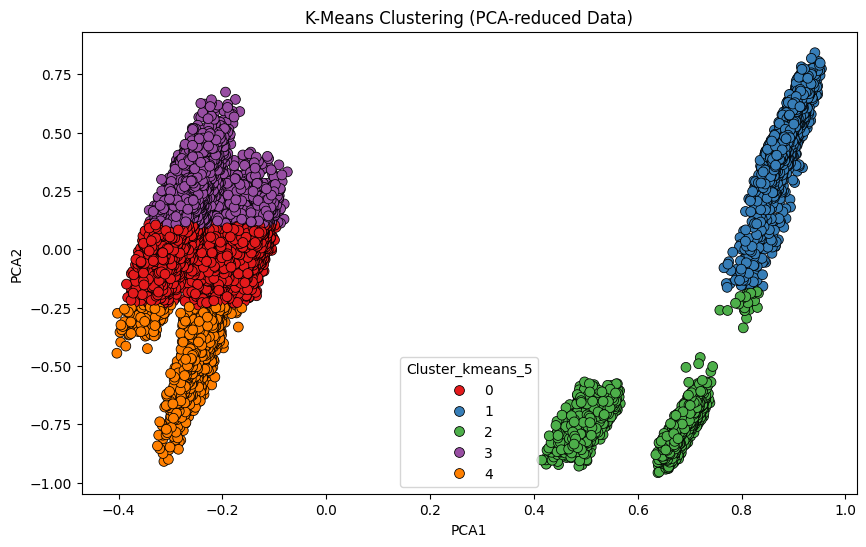

In [36]:


kmeans_5 = KMeans(n_clusters=5, random_state=42)
data['Cluster_kmeans_5'] = kmeans_5.fit_predict(X_pca)
data['Cluster_kmeans_5'] = kmeans_5.labels_
X_cluster['Cluster_kmeans_5']=data['Cluster_kmeans_5']
# Print cluster centers
print("Cluster Centers:\n", kmeans_5.cluster_centers_)

# Create a DataFrame with the PCA components and cluster labels
pca_df = pd.DataFrame(data=X_pca, columns=['PCA1', 'PCA2'])
pca_df['Cluster_kmeans_5'] = data['Cluster_kmeans_5']

# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='Cluster_kmeans_5', palette='Set1', s=50, edgecolor='k')
plt.title('K-Means Clustering (PCA-reduced Data)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster_kmeans_5')
plt.show()


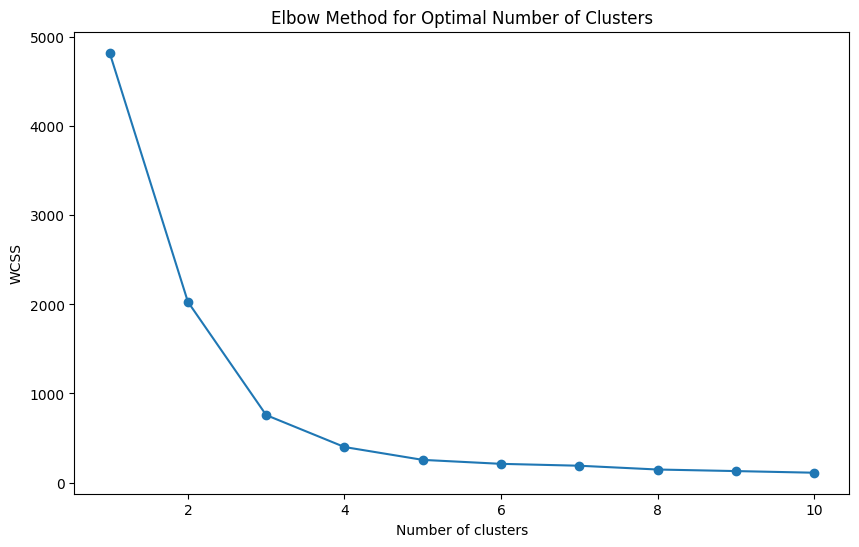

In [37]:
# Elbow method to determine the optimal number of clusters
wcss = []  # within-cluster sum of squares

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_pca)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [38]:
# # Print cluster centers
# cluster_centers_kmeans_5 = pd.DataFrame(kmeans_5.cluster_centers_, columns=X.columns)
# print("Cluster Centers:\n", cluster_centers_kmeans_5)

In [39]:
# Analyze the number of points in each cluster
cluster_distribution = data['Cluster_kmeans_5'].value_counts().sort_index()
print("Cluster Distribution:\n", cluster_distribution)

Cluster Distribution:
 Cluster_kmeans_5
0    5840
1    2022
2    1549
3    4300
4    1288
Name: count, dtype: int64


Comparison Table:
 left_company        0    1
Cluster_kmeans_5          
0                 1.0  0.0
1                 0.0  1.0
2                 0.0  1.0
3                 1.0  0.0
4                 1.0  0.0


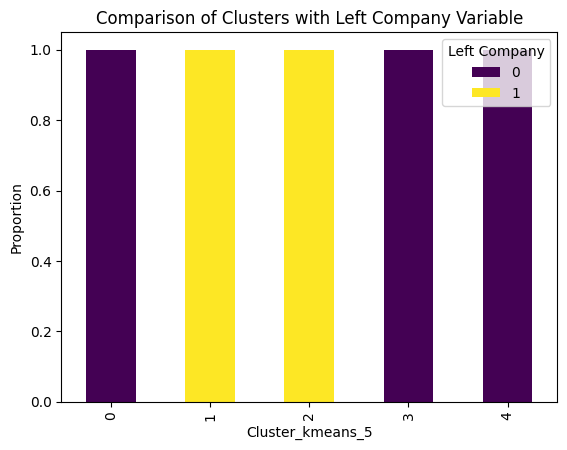

In [40]:
# Compare clusters with the 'left_company' variable
comparison_df = data[['Cluster_kmeans_5', 'left_company']]
comparison_table = pd.crosstab(comparison_df['Cluster_kmeans_5'], comparison_df['left_company'], normalize='index')
print("Comparison Table:\n", comparison_table)

# Visualize the comparison
comparison_table.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Comparison of Clusters with Left Company Variable')
plt.xlabel('Cluster_kmeans_5')
plt.ylabel('Proportion')
plt.legend(title='Left Company')
plt.show()

In [41]:
X_cluster.groupby('Cluster_kmeans_5').mean()

last_evaluation  number_project  average_montly_hours  \
Cluster_kmeans_5                                                          
0                        0.499438        0.312945              0.450082   
1                        0.806333        0.653017              0.745246   
2                        0.237411        0.003099              0.227473   
3                        0.699669        0.484279              0.590299   
4                        0.327737        0.134783              0.261523   

                  sensor_stepcount  sensor_heartbeat  left_company  
Cluster_kmeans_5                                                    
0                         0.352649          0.626553           0.0  
1                         0.066641          0.916452           1.0  
2                         0.331161          0.263460           1.0  
3                         0.451500          0.625566           0.0  
4                         0.127663          0.289467           0.0

### Four clusters

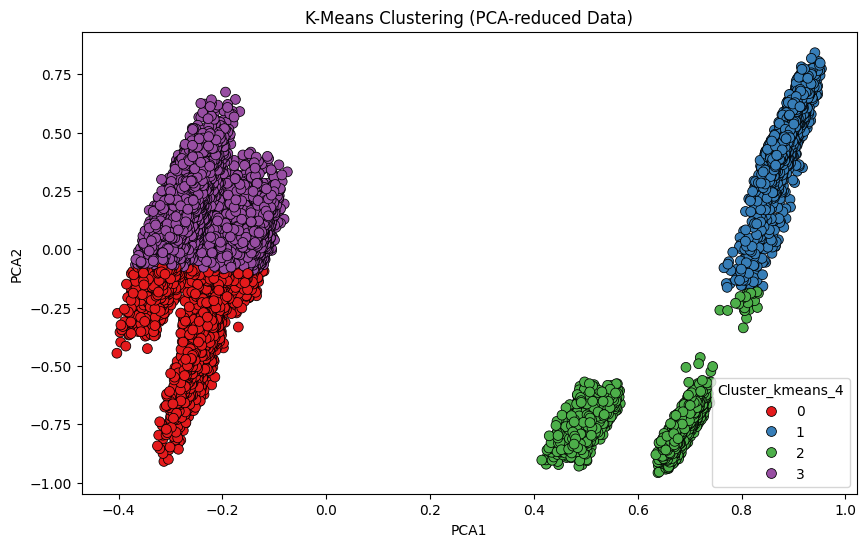

In [42]:


# # Standardize the selected features
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X_selected)

# Apply K-Means clustering
from sklearn.cluster import KMeans
kmeans_4 = KMeans(n_clusters=4, random_state=42)
data['Cluster_kmeans_4'] = kmeans_4.fit_predict(X_pca)
X_cluster['Cluster_kmeans_4']=data['Cluster_kmeans_4']

pca_df['Cluster_kmeans_4'] = data['Cluster_kmeans_4']

import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='Cluster_kmeans_4', palette='Set1', s=50, edgecolor='k')
plt.title('K-Means Clustering (PCA-reduced Data)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster_kmeans_4')
plt.show()

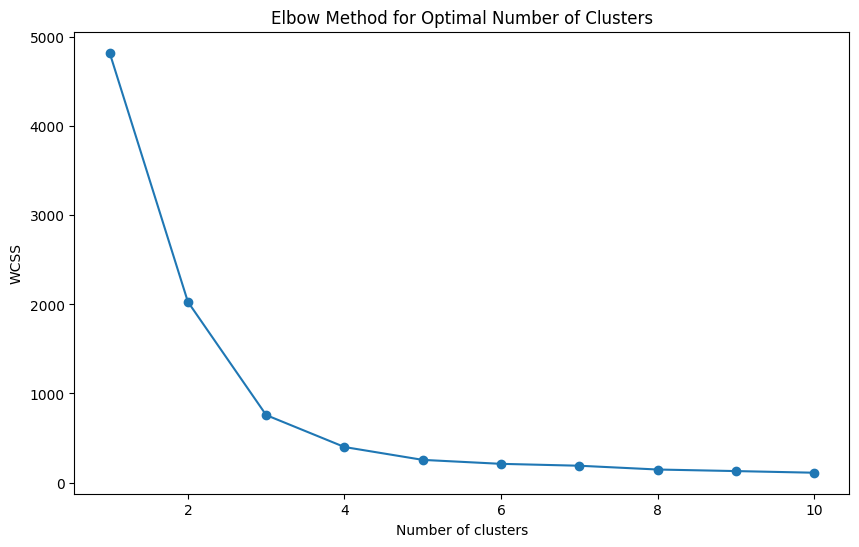

In [43]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Elbow method to determine the optimal number of clusters
wcss = []  # within-cluster sum of squares

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_pca)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss, marker='o')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

Comparison Table:
 left_company        0    1
Cluster_kmeans_4          
0                 1.0  0.0
1                 0.0  1.0
2                 0.0  1.0
3                 1.0  0.0


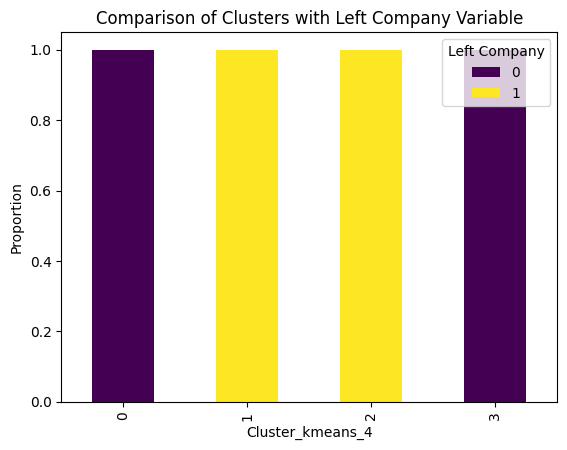

In [44]:
# Compare clusters with the 'left_company' variable
comparison_df = data[['Cluster_kmeans_4', 'left_company']]
comparison_table = pd.crosstab(comparison_df['Cluster_kmeans_4'], comparison_df['left_company'], normalize='index')
print("Comparison Table:\n", comparison_table)

# Visualize the comparison
comparison_table.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Comparison of Clusters with Left Company Variable')
plt.xlabel('Cluster_kmeans_4')
plt.ylabel('Proportion')
plt.legend(title='Left Company')
plt.show()

In [45]:
X_cluster.groupby('Cluster_kmeans_4').mean()

last_evaluation  number_project  average_montly_hours  \
Cluster_kmeans_4                                                          
0                        0.389220        0.178647              0.343869   
1                        0.806333        0.653017              0.745246   
2                        0.237411        0.003099              0.227473   
3                        0.607720        0.413551              0.524920   

                  sensor_stepcount  sensor_heartbeat  left_company  \
Cluster_kmeans_4                                                     
0                         0.251160          0.440926           0.0   
1                         0.066641          0.916452           1.0   
2                         0.331161          0.263460           1.0   
3                         0.400141          0.634522           0.0   

                  Cluster_kmeans_5  
Cluster_kmeans_4                    
0                         1.883729  
1                         1.000000  
2                         2.000000  
3                         1.483953

### Three clusters

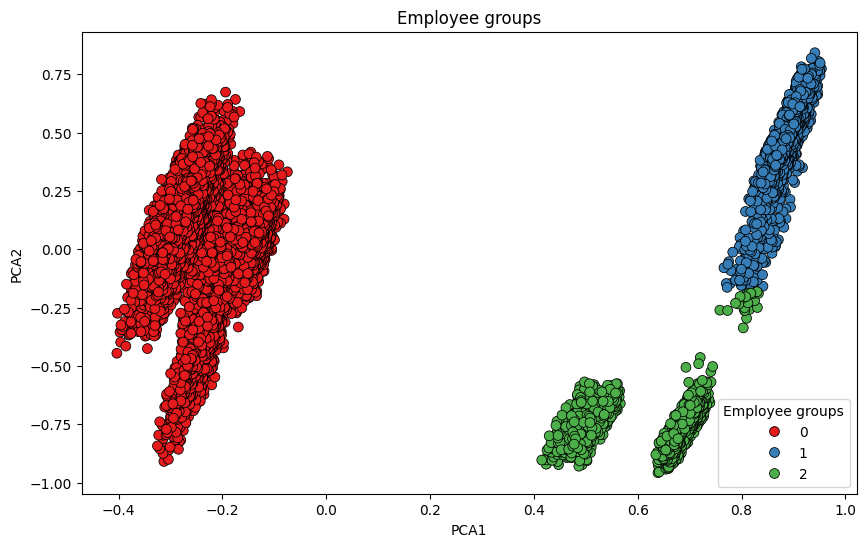

In [46]:
# Apply K-Means clustering
from sklearn.cluster import KMeans
kmeans_3 = KMeans(n_clusters=3, random_state=42)
data['Cluster_kmeans_3'] = kmeans_3.fit_predict(X_pca)
X_cluster['Cluster_kmeans_3']=data['Cluster_kmeans_3']

pca_df['Cluster_kmeans_3'] = data['Cluster_kmeans_3']

import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='Cluster_kmeans_3', palette='Set1', s=50, edgecolor='k')
# plt.title('K-Means Clustering (PCA-reduced Data)')
plt.title('Employee groups')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
# plt.legend(title='Cluster_kmeans_3')
plt.legend(title='Employee groups')
# plt.show()

#Save picture
plt.savefig('Employee_groups.png')

In [ ]:
# Compare clusters with the 'left_company' variable
comparison_df = data[['Cluster_kmeans_3', 'left_company']]
comparison_table = pd.crosstab(comparison_df['Cluster_kmeans_3'], comparison_df['left_company'], normalize='index')
print("Comparison Table:\n", comparison_table)

# Visualize the comparison
comparison_table.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Comparison of Clusters with Left Company Variable')
plt.xlabel('Cluster_kmeans_3')
plt.ylabel('Proportion')
plt.legend(title='Left Company')
plt.show()

In [ ]:
X_cluster.groupby('Cluster_kmeans_3').mean()

### Two custers

In [ ]:
# Apply K-Means clustering
from sklearn.cluster import KMeans
kmeans_2 = KMeans(n_clusters=2, random_state=42)
data['Cluster_kmeans_2'] = kmeans_2.fit_predict(X_pca)
X_cluster['Cluster_kmeans_2']=data['Cluster_kmeans_2']
pca_df['Cluster_kmeans_2'] = data['Cluster_kmeans_2']

import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='Cluster_kmeans_2', palette='Set1', s=50, edgecolor='k')
plt.title('K-Means Clustering (PCA-reduced Data)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster_kmeans_2')
plt.show()

In [ ]:
X_cluster.groupby('Cluster_kmeans_2').mean()

In [ ]:
# Compare clusters with the 'left_company' variable
comparison_df = data[['Cluster_kmeans_2', 'left_company']]
comparison_table = pd.crosstab(comparison_df['Cluster_kmeans_2'], comparison_df['left_company'], normalize='index')
print("Comparison Table:\n", comparison_table)

# Visualize the comparison
comparison_table.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Comparison of Clusters with Left Company Variable')
plt.xlabel('Cluster_kmeans_2')
plt.ylabel('Proportion')
plt.legend(title='Left Company')
plt.show()

### Six clusters

In [ ]:
# Apply K-Means clustering
from sklearn.cluster import KMeans
kmeans_6 = KMeans(n_clusters=6, random_state=42)
data['Cluster_kmeans_6'] = kmeans_6.fit_predict(X_pca)
X_cluster['Cluster_kmeans_6']=data['Cluster_kmeans_6']
pca_df['Cluster_kmeans_6'] = data['Cluster_kmeans_6']

import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='Cluster_kmeans_6', palette='Set1', s=50, edgecolor='k')
plt.title('K-Means Clustering (PCA-reduced Data)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster_kmeans_6')
plt.show()

In [ ]:
X_cluster.groupby('Cluster_kmeans_6').mean()

In [ ]:
# Compare clusters with the 'left_company' variable
comparison_df = data[['Cluster_kmeans_6', 'left_company']]
comparison_table = pd.crosstab(comparison_df['Cluster_kmeans_6'], comparison_df['left_company'], normalize='index')
print("Comparison Table:\n", comparison_table)

# Visualize the comparison
comparison_table.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Comparison of Clusters with Left Company Variable')
plt.xlabel('Cluster_kmeans_6')
plt.ylabel('Proportion')
plt.legend(title='Left Company')
plt.show()

### Comparing the number of clusters

In [ ]:
# Could be used here as well
#Using Silhouette Scores to identify the right number of clusters
k = [2,3,4,5,6] 
  
# Appending the silhouette scores of the different models to the list 
silhouette_scores = [] 
silhouette_scores.append( 
        silhouette_score(X_pca, kmeans_2.fit_predict(X_pca))) 
silhouette_scores.append( 
        silhouette_score(X_pca, kmeans_3.fit_predict(X_pca))) 
silhouette_scores.append( 
        silhouette_score(X_pca, kmeans_4.fit_predict(X_pca))) 
silhouette_scores.append( 
        silhouette_score(X_pca, kmeans_5.fit_predict(X_pca))) 
silhouette_scores.append( 
        silhouette_score(X_pca, kmeans_6.fit_predict(X_pca))) 
  
# Plotting a bar graph to compare the results 
plt.bar(k, silhouette_scores) 
plt.xlabel('Number of clusters', fontsize = 20) 
plt.ylabel('S(i)', fontsize = 20) 
plt.show() 

## AgglomerativeClustering

### PCA

In [ ]:
# # PCA

# pca = PCA(n_components = 2) 
# X_principal = pca.fit_transform(X) 
# X_principal = pd.DataFrame(X_principal) 
# X_principal.columns = ['PCA1', 'PCA2'] 


In [ ]:
plt.figure(figsize =(8, 8)) 
plt.title('Visualising the data') 
Dendrogram = shc.dendrogram((shc.linkage(X_pca, method ='ward'))) 

### Two Clusters

In [ ]:
#Agglomerative Clustering / Ward hierarchical clustering
ac2 = AgglomerativeClustering(n_clusters = 2) 
# plt.figure(figsize =(6, 6)) 
# plt.scatter(X_principal['PCA1'], X_principal['PCA2'],  
#            c = ac2.fit_predict(X_principal), cmap ='rainbow') 
# plt.show()

data['Cluster_ac2'] = ac2.fit_predict(X_pca)
ac2_df = pd.DataFrame(data=X_pca, columns=['PCA1', 'PCA2'])
ac2_df['Cluster_ac2'] = data['Cluster_ac2']
X_cluster['Cluster_ac2']=data['Cluster_ac2']

# Plot the clusters with customized appearance
plt.figure(figsize=(10, 6))
sns.scatterplot(data=ac2_df, x='PCA1', y='PCA2', hue='Cluster_ac2', palette='Set1', s=50, edgecolor='k')
plt.title('Agglomerative Clustering (PCA-reduced Data)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster_ac2')
plt.show()


In [ ]:
cluster_distribution = data['Cluster_ac2'].value_counts().sort_index()
cluster_distribution

In [ ]:
comparison_df = data[['Cluster_ac2', 'left_company']]
comparison_table = pd.crosstab(comparison_df['Cluster_ac2'], comparison_df['left_company'], normalize='index')
print("Comparison Table:\n", comparison_table)

# Visualize the comparison
comparison_table.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Comparison of Clusters with Left Company Variable')
plt.xlabel('Cluster_ac2')
plt.ylabel('Proportion')
plt.legend(title='Left Company')
plt.show()

In [ ]:
X_cluster.groupby('Cluster_ac2').mean()

### Three Clusters

In [ ]:
ac3 = AgglomerativeClustering(n_clusters = 3) 
data['Cluster_ac3'] = ac3.fit_predict(X_pca)
ac3_df = pd.DataFrame(data=X_pca, columns=['PCA1', 'PCA2'])
ac3_df['Cluster_ac3'] = data['Cluster_ac3']
X_cluster['Cluster_ac3']=data['Cluster_ac3']

# Plot the clusters with customized appearance
plt.figure(figsize=(10, 6))
sns.scatterplot(data=ac3_df, x='PCA1', y='PCA2', hue='Cluster_ac3', palette='Set1', s=50, edgecolor='k')
plt.title('Agglomerative Clustering (PCA-reduced Data)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster_ac3')
plt.show()


In [ ]:
cluster_distribution = data['Cluster_ac3'].value_counts().sort_index()
cluster_distribution

In [ ]:
comparison_df = data[['Cluster_ac3', 'left_company']]
comparison_table = pd.crosstab(comparison_df['Cluster_ac3'], comparison_df['left_company'], normalize='index')
print("Comparison Table:\n", comparison_table)

# Visualize the comparison
comparison_table.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Comparison of Clusters with Left Company Variable')
plt.xlabel('Cluster_ac3')
plt.ylabel('Proportion')
plt.legend(title='Left Company')
plt.show()

In [ ]:
X_cluster.groupby('Cluster_ac3').mean()

### Four clusters

In [ ]:
ac4 = AgglomerativeClustering(n_clusters = 4) 
data['Cluster_ac4'] = ac4.fit_predict(X_pca)
ac4_df = pd.DataFrame(data=X_pca, columns=['PCA1', 'PCA2'])
ac4_df['Cluster_ac4'] = data['Cluster_ac4']
X_cluster['Cluster_ac4']=data['Cluster_ac4']

# Plot the clusters with customized appearance
plt.figure(figsize=(10, 6))
sns.scatterplot(data=ac4_df, x='PCA1', y='PCA2', hue='Cluster_ac4', palette='Set1', s=50, edgecolor='k')
plt.title('Agglomerative Clustering (PCA-reduced Data)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster_ac4')
plt.show()

In [ ]:
cluster_distribution = data['Cluster_ac4'].value_counts().sort_index()
cluster_distribution

In [ ]:
comparison_df = data[['Cluster_ac4', 'left_company']]
comparison_table = pd.crosstab(comparison_df['Cluster_ac4'], comparison_df['left_company'], normalize='index')
print("Comparison Table:\n", comparison_table)

# Visualize the comparison
comparison_table.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Comparison of Clusters with Left Company Variable')
plt.xlabel('Cluster_ac4')
plt.ylabel('Proportion')
plt.legend(title='Left Company')
plt.show()

In [ ]:
X_cluster.groupby('Cluster_ac4').mean()

### Five clusters

In [ ]:
ac5 = AgglomerativeClustering(n_clusters = 5) 
data['Cluster_ac5'] = ac5.fit_predict(X_pca)
ac5_df = pd.DataFrame(data=X_pca, columns=['PCA1', 'PCA2'])
ac5_df['Cluster_ac5'] = data['Cluster_ac5']
X_cluster['Cluster_ac5']=data['Cluster_ac5']

# Plot the clusters with customized appearance
plt.figure(figsize=(10, 6))
sns.scatterplot(data=ac5_df, x='PCA1', y='PCA2', hue='Cluster_ac5', palette='Set1', s=50, edgecolor='k')
plt.title('Agglomerative Clustering (PCA-reduced Data)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster_ac5')
plt.show()

In [ ]:
cluster_distribution = data['Cluster_ac5'].value_counts().sort_index()
cluster_distribution

In [ ]:
comparison_df = data[['Cluster_ac5', 'left_company']]
comparison_table = pd.crosstab(comparison_df['Cluster_ac5'], comparison_df['left_company'], normalize='index')
print("Comparison Table:\n", comparison_table)

# Visualize the comparison
comparison_table.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Comparison of Clusters with Left Company Variable')
plt.xlabel('Cluster_ac5')
plt.ylabel('Proportion')
plt.legend(title='Left Company')
plt.show()

In [ ]:
X_cluster.groupby('Cluster_ac5').mean()

### Six clusters

In [ ]:
ac6 = AgglomerativeClustering(n_clusters = 6) 
data['Cluster_ac6'] = ac6.fit_predict(X_pca)
ac6_df = pd.DataFrame(data=X_pca, columns=['PCA1', 'PCA2'])
ac6_df['Cluster_ac6'] = data['Cluster_ac6']
X_cluster['Cluster_ac6']=data['Cluster_ac6']

# Plot the clusters with customized appearance
plt.figure(figsize=(10, 6))
sns.scatterplot(data=ac6_df, x='PCA1', y='PCA2', hue='Cluster_ac6', palette='Set1', s=50, edgecolor='k')
plt.title('Agglomerative Clustering (PCA-reduced Data)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(title='Cluster_ac6')
plt.show()

In [ ]:
cluster_distribution = data['Cluster_ac6'].value_counts().sort_index()
cluster_distribution

In [ ]:
comparison_df = data[['Cluster_ac6', 'left_company']]
comparison_table = pd.crosstab(comparison_df['Cluster_ac6'], comparison_df['left_company'], normalize='index')
print("Comparison Table:\n", comparison_table)

# Visualize the comparison
comparison_table.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Comparison of Clusters with Left Company Variable')
plt.xlabel('Cluster_ac6')
plt.ylabel('Proportion')
plt.legend(title='Left Company')
plt.show()

In [ ]:
X_cluster.groupby('Cluster_ac6').mean()

## Comparing number of clusters

In [ ]:
# Using Silhouette Scores to identify the right number of clusters
k = [2, 3, 4, 5, 6] 
  
# Appending the silhouette scores of the different models to the list 
silhouette_scores = [] 
silhouette_scores.append( 
        silhouette_score(X_pca, ac2.fit_predict(X_pca))) 
silhouette_scores.append( 
        silhouette_score(X_pca, ac3.fit_predict(X_pca))) 
silhouette_scores.append( 
        silhouette_score(X_pca, ac4.fit_predict(X_pca))) 
silhouette_scores.append( 
        silhouette_score(X_pca, ac5.fit_predict(X_pca))) 
silhouette_scores.append( 
        silhouette_score(X_pca, ac6.fit_predict(X_pca))) 
  
# Plotting a bar graph to compare the results 
plt.bar(k, silhouette_scores) 
plt.xlabel('Number of clusters', fontsize = 20) 
plt.ylabel('S(i)', fontsize = 20) 
plt.show() 

## DBSCAN Clustering

### k-distance graph

In [ ]:
# estimating eps value 
k = 9  # min_samples - 1
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)

distances = np.sort(distances[:, k-1], axis=0)
plt.plot(distances)
plt.xlabel('Data Points')
plt.ylabel('k-Distance')
plt.title('k-Distance Graph')
plt.show()


In [ ]:

eps =0.125 # the one for 5 features: 0.375  
min_samples = 10

#Run DBSCAN and evaluate
db_1 = DBSCAN(eps=eps, min_samples=min_samples).fit(X_scaled)
core_samples_mask = np.zeros_like(db_1.labels_, dtype=bool)
core_samples_mask[db_1.core_sample_indices_] = True
labels = db_1.labels_
data['Cluster_db_1'] = db_1.fit_predict(X_scaled) 
X_cluster['Cluster_db_1']=data['Cluster_db_1']

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

labels = db_1.fit_predict(X_scaled)

if len(set(labels)) > 1:
    silhouette_avg = silhouette_score(X_scaled, labels)
    print(f"Silhouette Score: {silhouette_avg}")
else:
    print("All points are noise or a single cluster.")



In [ ]:
cluster_distribution = data['Cluster_db_1'].value_counts().sort_index()
cluster_distribution

In [ ]:
comparison_df = data[['Cluster_db_1', 'left_company']]
comparison_table = pd.crosstab(comparison_df['Cluster_db_1'], comparison_df['left_company'], normalize='index')
print("Comparison Table:\n", comparison_table)

# Visualize the comparison
comparison_table.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Comparison of Clusters with Left Company Variable')
plt.xlabel('Cluster_db_1')
plt.ylabel('Proportion')
plt.legend(title='Left Company')
plt.show()

In [ ]:
X_cluster.groupby('Cluster_db_1').mean()

### k-distance graph

In [ ]:
# estimating eps value 
k = 4  # min_samples - 1
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)

distances = np.sort(distances[:, k-1], axis=0)
plt.plot(distances)
plt.xlabel('Data Points')
plt.ylabel('k-Distance')
plt.title('k-Distance Graph')
plt.show()


In [ ]:

eps = 0.2  
min_samples = 5

#Run DBSCAN and evaluate
db_2 = DBSCAN(eps=eps, min_samples=min_samples).fit(X_scaled)
core_samples_mask = np.zeros_like(db_2.labels_, dtype=bool)
core_samples_mask[db_2.core_sample_indices_] = True
labels = db_2.labels_
data['Cluster_db_2'] = db_2.fit_predict(X_scaled)
X_cluster['Cluster_db_2']=data['Cluster_db_2']

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

labels = db_2.fit_predict(X_scaled)

if len(set(labels)) > 1:
    silhouette_avg = silhouette_score(X_scaled, labels)
    print(f"Silhouette Score: {silhouette_avg}")
else:
    print("All points are noise or a single cluster.")

In [ ]:
cluster_distribution = data['Cluster_db_2'].value_counts().sort_index()
cluster_distribution

In [ ]:
comparison_df = data[['Cluster_db_2', 'left_company']]
comparison_table = pd.crosstab(comparison_df['Cluster_db_2'], comparison_df['left_company'], normalize='index')
print("Comparison Table:\n", comparison_table)

# Visualize the comparison
comparison_table.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Comparison of Clusters with Left Company Variable')
plt.xlabel('Cluster_db_2')
plt.ylabel('Proportion')
plt.legend(title='Left Company')
plt.show()

In [ ]:
X_cluster.groupby('Cluster_db_2').mean()

### k-distance graph

In [ ]:
# estimating eps value 
k = 14  # min_samples - 1
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)

distances = np.sort(distances[:, k-1], axis=0)
plt.plot(distances)
plt.xlabel('Data Points')
plt.ylabel('k-Distance')
plt.title('k-Distance Graph')
plt.show()


In [ ]:

eps = 0.5  # the one for 5 features: 0.375
min_samples = 15

#Run DBSCAN and evaluate
db_3 = DBSCAN(eps=eps, min_samples=min_samples).fit(X_scaled)
core_samples_mask = np.zeros_like(db_3.labels_, dtype=bool)
core_samples_mask[db_3.core_sample_indices_] = True
labels = db_3.labels_
data['Cluster_db_3'] = db_3.fit_predict(X_scaled) 
X_cluster['Cluster_db_3']=data['Cluster_db_3']

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

labels = db_3.fit_predict(X_scaled)

if len(set(labels)) > 1:
    silhouette_avg = silhouette_score(X_scaled, labels)
    print(f"Silhouette Score: {silhouette_avg}")
else:
    print("All points are noise or a single cluster.")

In [ ]:
cluster_distribution = data['Cluster_db_3'].value_counts().sort_index()
cluster_distribution

In [ ]:
comparison_df = data[['Cluster_db_3', 'left_company']]
comparison_table = pd.crosstab(comparison_df['Cluster_db_3'], comparison_df['left_company'], normalize='index')
print("Comparison Table:\n", comparison_table)

# Visualize the comparison
comparison_table.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Comparison of Clusters with Left Company Variable')
plt.xlabel('Cluster_db_3')
plt.ylabel('Proportion')
plt.legend(title='Left Company')
plt.show()

In [ ]:
X_cluster.groupby('Cluster_db_3').mean()

### k-distance graph

In [ ]:
# estimating eps value 
k = 19  # min_samples - 1
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)

distances = np.sort(distances[:, k-1], axis=0)
plt.plot(distances)
plt.xlabel('Data Points')
plt.ylabel('k-Distance')
plt.title('k-Distance Graph')
plt.show()


In [ ]:

eps = 0.375  
min_samples = 20

#Run DBSCAN and evaluate
db_4 = DBSCAN(eps=eps, min_samples=min_samples).fit(X_scaled)
core_samples_mask = np.zeros_like(db_4.labels_, dtype=bool)
core_samples_mask[db_4.core_sample_indices_] = True
labels = db_4.labels_
data['Cluster_db_4'] = db_4.fit_predict(X_scaled)
X_cluster['Cluster_db_4']=data['Cluster_db_4']

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

labels = db_4.fit_predict(X_scaled)

if len(set(labels)) > 1:
    silhouette_avg = silhouette_score(X_scaled, labels)
    print(f"Silhouette Score: {silhouette_avg}")
else:
    print("All points are noise or a single cluster.")

In [ ]:
cluster_distribution = data['Cluster_db_4'].value_counts().sort_index()
cluster_distribution

In [ ]:
comparison_df = data[['Cluster_db_4', 'left_company']]
comparison_table = pd.crosstab(comparison_df['Cluster_db_4'], comparison_df['left_company'], normalize='index')
print("Comparison Table:\n", comparison_table)

# Visualize the comparison
comparison_table.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Comparison of Clusters with Left Company Variable')
plt.xlabel('Cluster_db_4')
plt.ylabel('Proportion')
plt.legend(title='Left Company')
plt.show()

In [ ]:
X_cluster.groupby('Cluster_db_4').mean()

### k-distance graph

In [ ]:
# estimating eps value 
k = 9  # min_samples - 1
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(X_scaled)
distances, indices = neighbors_fit.kneighbors(X_scaled)

distances = np.sort(distances[:, k-1], axis=0)
plt.plot(distances)
plt.xlabel('Data Points')
plt.ylabel('k-Distance')
plt.title('k-Distance Graph')
plt.show()


In [ ]:

eps = 0.2  
min_samples = 6

#Run DBSCAN and evaluate
db_5 = DBSCAN(eps=eps, min_samples=min_samples).fit(X_scaled)
core_samples_mask = np.zeros_like(db_5.labels_, dtype=bool)
core_samples_mask[db_5.core_sample_indices_] = True
labels = db_5.labels_
data['Cluster_db_5'] = db_5.fit_predict(X_scaled) 
X_cluster['Cluster_db_5']=data['Cluster_db_5']

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

labels = db_5.fit_predict(X_scaled)

if len(set(labels)) > 1:
    silhouette_avg = silhouette_score(X_scaled, labels)
    print(f"Silhouette Score: {silhouette_avg}")
else:
    print("All points are noise or a single cluster.")

In [ ]:
cluster_distribution = data['Cluster_db_5'].value_counts().sort_index()
cluster_distribution

In [ ]:
comparison_df = data[['Cluster_db_5', 'left_company']]
comparison_table = pd.crosstab(comparison_df['Cluster_db_5'], comparison_df['left_company'], normalize='index')
print("Comparison Table:\n", comparison_table)

# Visualize the comparison
comparison_table.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Comparison of Clusters with Left Company Variable')
plt.xlabel('Cluster_db_5')
plt.ylabel('Proportion')
plt.legend(title='Left Company')
plt.show()

In [ ]:
X_cluster.groupby('Cluster_db_5').mean()

## Gaussian mixtures clustering

### Determining the optimal number of clusters

In [ ]:
#Prepare
n_conponent = np.arange(1,10)

#Create GGM Model
models = [GaussianMixture(n_components = n,
                          random_state=42).fit(X_scaled) for n in n_conponent]
#Plot
plt.plot(n_conponent,
         [m.bic(X_scaled) for m in models],
         label = 'BIC')
plt.plot(n_conponent,
         [m.aic(X_scaled) for m in models],
         label = 'BIC')
plt.legend()
plt.xlabel("Number Of Component")

In [ ]:
# create GM Models
model_gauss = GaussianMixture(n_components=4,
                        random_state=42).fit(X_scaled)
cluster_Gaussian_1 = pd.Series(model_gauss.predict(X_scaled))
X_cluster['cluster_Gaussian_1'] = cluster_Gaussian_1
X_cluster

In [ ]:
X_cluster.cluster_Gaussian_1.value_counts()

In [ ]:
data['cluster_Gaussian_1'] = cluster_Gaussian_1
comparison_df = data[['cluster_Gaussian_1', 'left_company']]
comparison_table = pd.crosstab(comparison_df['cluster_Gaussian_1'], comparison_df['left_company'], normalize='index')
print("Comparison Table:\n", comparison_table)

# Visualize the comparison
comparison_table.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Comparison of Clusters with Left Company Variable')
plt.xlabel('cluster_Gaussian_1')
plt.ylabel('Proportion')
plt.legend(title='Left Company')
plt.show()

In [ ]:
X_cluster.groupby('cluster_Gaussian_1').mean()